# Logistic regression model

In [1]:
# Standard library imports
from typing import Tuple

# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_curve, precision_recall_curve

# Random state
random_state=315

# Input data
data_file='../data/resampled_disaster_data_all.parquet'

## 1. Data loading

In [2]:
data_df=pd.read_parquet(data_file)

total_disaster_months=len(data_df[data_df['incidents_binary'] != 0])
percent_disaster_months=(total_disaster_months/len(data_df)) * 100
print(f'Have {total_disaster_months}({percent_disaster_months:.1f}%) disaster months\n')

data_df.info()

Have 1986(4.7%) disaster months

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 41899 entries, (np.int64(1955), 'AK', np.int64(1)) to (np.int64(2019), 'WY', np.int64(12))
Data columns (total 70 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   incidents                             41899 non-null  int64  
 1   month_sin                             41899 non-null  float64
 2   month_cos                             41899 non-null  float64
 3   AL                                    41899 non-null  int64  
 4   AR                                    41899 non-null  int64  
 5   AS                                    41899 non-null  int64  
 6   AZ                                    41899 non-null  int64  
 7   CA                                    41899 non-null  int64  
 8   CO                                    41899 non-null  int64  
 9   CT                                    41899 non-nul

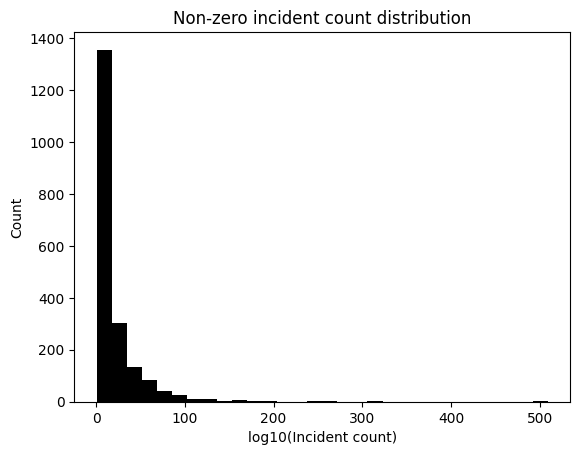

In [3]:
# Draw a quick plot to check the distribution of disaster counts
plt.title('Non-zero incident count distribution')
plt.hist(data_df['incidents'][data_df['incidents'] != 0], bins=30, color='black')
plt.xlabel('log10(Incident count)')
plt.ylabel('Count')
plt.show()

## 2. Data reshaping function

In [4]:
def generate_data(data_df: pd.DataFrame) -> Tuple[np.array, np.array]:
    '''Takes dataframe, parses data into feature label pairs where label
    is binarized incidents from the next month. Returns as tuple of numpy arrays'''

    # Get list of states
    states=data_df.index.get_level_values('state').unique().tolist()

    features=[]
    labels=[]

    # Loop on states
    for state in states:

        # Extract the data for this state
        state_df=data_df.loc[:,state,:]

        # Indexing variable for batch
        input_start_index=0

        # Loop on the state data
        while input_start_index + 1 < len(state_df):

            # Extract and collect the features
            features.append(state_df.iloc[input_start_index, :-1].values.tolist())

            # Extract and collect the labels
            labels.append(state_df.iloc[input_start_index + 1, -1])

            # Update the index
            input_start_index+=1

    return np.array(features), np.array(labels)

## 3. Train-test split

In [5]:
# Generate feature, label pairs
features, labels=generate_data(data_df)

In [6]:
# Split features and labels into training and validation
training_features, testing_features, training_labels, testing_labels=train_test_split(
    features,
    labels,
    random_state=random_state
)

Training features: (31380, 69)
Training labels: (31380,), 4.7% positive class
Testing features: (10460, 69)
Testing labels: (10460,), 4.8% positive class


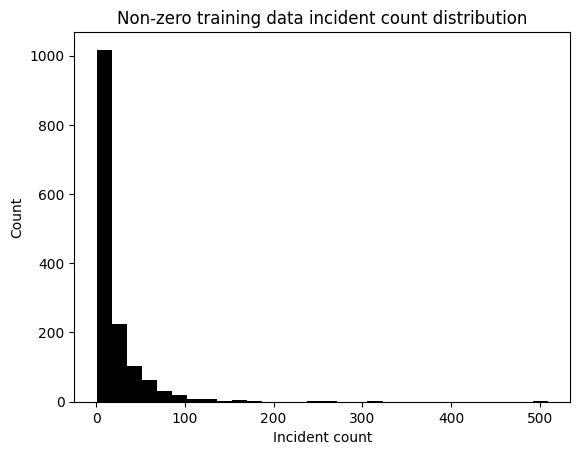

In [7]:
# Sanity check data shape and distribution
print(f'Training features: {training_features.shape}')
print(f'Training labels: {training_labels.shape}, {(sum(training_labels)/len(training_labels))*100:.1f}% positive class')
print(f'Testing features: {testing_features.shape}')
print(f'Testing labels: {testing_labels.shape}, {(sum(testing_labels)/len(testing_labels))*100:.1f}% positive class')

# Draw a quick plot to check the distribution of disaster counts
training_disaster_counts=training_features[:,0].flatten()
nonzero_training_disaster_counts=training_disaster_counts[np.nonzero(training_disaster_counts)]

plt.title('Non-zero training data incident count distribution')
plt.hist(nonzero_training_disaster_counts, bins=30, color='black')
plt.xlabel('Incident count')
plt.ylabel('Count')
plt.show()

## 4. Model fitting

In [8]:
model=LogisticRegression(
    class_weight='balanced',
    random_state=random_state,
    max_iter=10000
).fit(training_features, training_labels)

## 5. Model evaluation

### 5.1. Make predictions on test set

In [9]:
# Make predictions on the test set
predictions=model.predict_proba(testing_features)

# Convert to NumPy
predictions=np.array(predictions)
testing_labels=np.array(testing_labels)

# Get positive class probability
predictions=predictions[:,1]

# Make predictions dataframe
predictions_df=pd.DataFrame.from_dict({'labels': testing_labels, 'probabilities': predictions})
predictions_df.head()

,labels,probabilities
0,0,0.287540
1,0,0.455174
2,0,0.510888
3,1,0.644475
4,0,0.475272


### 5.2. Distribution of predicted incident probabilities

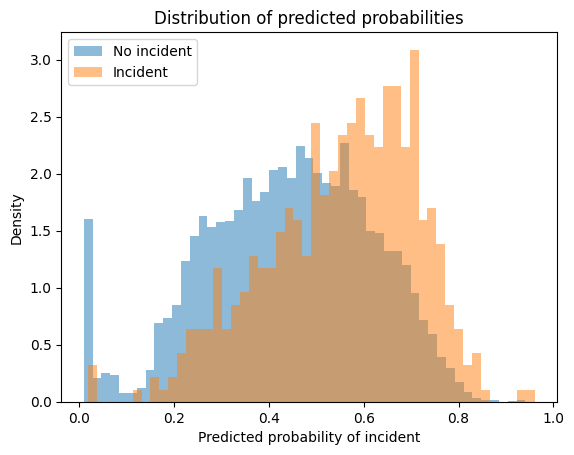

In [13]:
plt.title('Distribution of predicted probabilities')
plt.hist(predictions_df['probabilities'][predictions_df['labels'] == 0], bins=50, density=True, alpha=0.5, label='No incident')
plt.hist(predictions_df['probabilities'][predictions_df['labels'] == 1], bins=50, density=True, alpha=0.5, label='Incident')
plt.xlabel('Predicted probability of incident')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

### 5.3. Receiver-operator characteristic and precision-recall curves

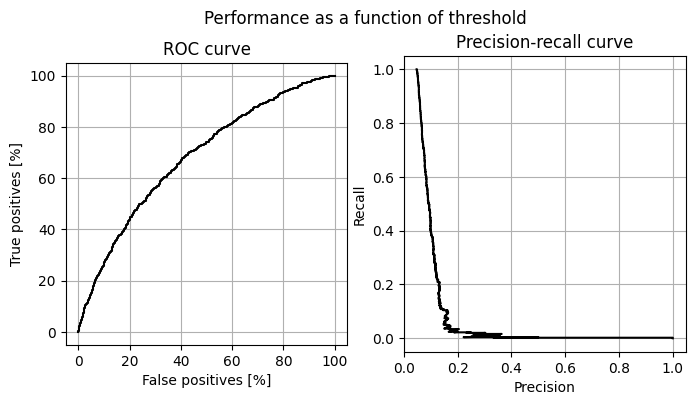

In [14]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('Performance as a function of threshold', size='large')

# Plot ROC curve
fp, tp, _ = roc_curve(predictions_df['labels'], predictions_df['probabilities'])
axs[0].set_title('ROC curve')
axs[0].plot(100*fp, 100*tp, color='black')
axs[0].set_xlabel('False positives [%]')
axs[0].set_ylabel('True positives [%]')
axs[0].grid(True)
axs[0].set_aspect('equal')

# Plot PR curve
precision, recall, _ = precision_recall_curve(predictions_df['labels'], predictions_df['probabilities'])
axs[1].set_title('Precision-recall curve')
axs[1].plot(precision, recall, color='black')
axs[1].set_xlabel('Precision')
axs[1].set_ylabel('Recall')
axs[1].grid(True)
axs[1].set_aspect('equal')

### 5.4. Confusion matrix

Precision: 0.090
Recall: 0.506



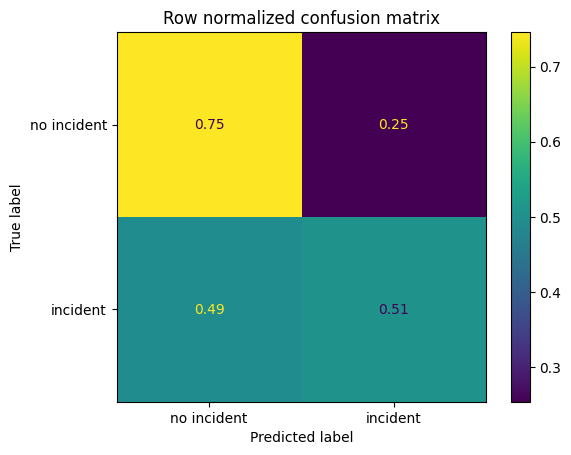

In [15]:
# Set threshold and call incidents
threshold=0.57
calls=np.where(predictions_df['probabilities'] > threshold, 1, 0)

# Calculate precision and recall
precision=precision_score(testing_labels, calls)
recall=recall_score(testing_labels, calls)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}\n')

# Plot the confusion matrix
cm=confusion_matrix(predictions_df['labels'], calls, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no incident', 'incident'])
_=cm_disp.plot()
plt.title('Row normalized confusion matrix')
plt.show()